In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

DATA_ORI = 'C:\\Users\\gcram\\Documents\\Smart Sense\\Datasets\\originals\\PAMAP2\\Protocol\\*.dat'
DATA_DIR = 'C:\\Users\\gcram\\Documents\\Smart Sense\\Datasets\\frankDataset\\'


In [27]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [28]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='C:\\Users\\gcram\\Documents\\Smart Sense\\Datasets\\originals\\PAMAP2\\Protocol\\subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [29]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [30]:
data = data.iloc[:, 1:13]
data = data.drop(['heart_rate','hand_temperature','hand_3D_acceleration_6_x','hand_3D_acceleration_6_y','hand_3D_acceleration_6_z'], axis=1)
data.head()

,activity_id,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z
2928,1,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145
2929,1,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538
2930,1,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831
2931,1,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374
2932,1,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582


In [31]:
desired_act = [1,4,12,13]
not_desired= [2,3,5,6,7,8,9,10,11,14,15,16,17,18,19,20,21,22,23,24,25]
for a in not_desired:
    data = data.drop(data[data['activity_id']==a].index)

In [64]:
lines = data.to_numpy(dtype='float')
curr_act = 25
sub_s = []
semple_len = 256
x = []
y = []
for l in lines:
    act =int(l[0])
    if(curr_act != act and len(sub_s)>1):
        print(len(sub_s))
        for i in range(int(len(sub_s)/semple_len)):
            ini = i*semple_len
            end = (i+1)*semple_len
            x.append(sub_s[ini:end])
            y.append(act)
#         if (len(sub_s)%semple_len) !=0:
#             x.append(sub_s[0:semple_len])
#             y.append(act)
        sub_s = []
    sub_s.append(l[1:])
    curr_act = act
dataX = np.array(x, dtype=float)
dataY = np.array(y)

27187
8120
7480
7770
7419
22253
23430
8725
7791
8617
7422
32533
22044
5764
5435
4867
4954
4644
29036
23047
8535
7328
8159
6957
31932
23699
6110
6982
8171
5745
32033
23340
6232
6173
7059
5099
25721
25611
9102
6290
8544
5328
33720
24165
5901
4846
5782
4809


In [65]:
dataX.shape

(2407, 256, 6)

### Analysig the Original Dataset:

In [68]:
x_axis = []
subj = {}
for file in glob.glob(DATA_ORI):
    print(file)
    for a in [1,4,12,13]:
        subj[file.split('.')[0][-4:]+'_' +str(a)] = [ ]
    with open(file) as f:
        lines = f.readlines()
    for line in lines:
        #get the x axis of the second Acc
        l = line.split(' ')
        act =int(l[1]) 
        if act == 1 or act == 4 or act == 12 or act == 13:
            s = np.array(l[7:13]).astype('float')
            subj[file.split('.')[0][-4:] +'_' +str(act)].append(s)


C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject101.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject102.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject103.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject104.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject105.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject106.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject107.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject108.dat
C:\Users\gcram\Documents\Smart Sense\Datasets\originals\PAMAP2\Protocol\subject109.dat


In [76]:
x = np.array(subj['t101_1'])
freq = 100
t = 2
data = []
N = int(len(x)/(freq*t))
for i in range(N-1):
    data.append(x[i*freq*t:(i+1)*freq*t])
data = np.stack(data)


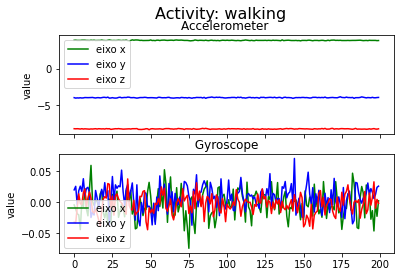

In [84]:
sample = -56
x = data[sample]
label ='walking'
sensors = ['Accelerometer', ' Gyroscope']
n_sensors = 2
axis = [' x', ' y', ' z']
f, axarr = plt.subplots(n_sensors, 1, sharex=True, sharey=False)
for i in range(n_sensors):
    axarr[i].plot(x[:, 3*i+0].tolist(), color='green', label='eixo x')
    axarr[i].plot(x[:, 3*i+1].tolist(), color='blue', label='eixo y')
    axarr[i].plot(x[:, 3*i+2].tolist(), color='red', label='eixo z')
    axarr[i].set_title(f'{sensors[i]} ')
    axarr[i].set_ylabel(f'value')
    axarr[i].legend()
f.suptitle(f'Activity: {label}', fontsize=16)
plt.show()

In [114]:
x = np.array(subj['t106_13'])
freq = 100
t = 2
data = []
N = int(len(x)/(freq*t))
for i in range(N-1):
    data.append(x[i*freq*t:(i+1)*freq*t])
data = np.stack(data)

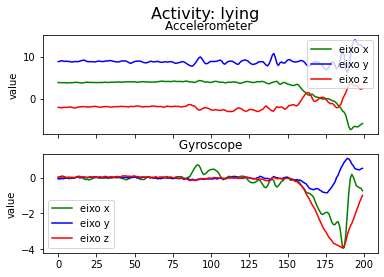

In [116]:
sample = 1

x = data[sample]
label ='lying'
sensors = ['Accelerometer', ' Gyroscope']
n_sensors = 2
axis = [' x', ' y', ' z']
f, axarr = plt.subplots(n_sensors, 1, sharex=True, sharey=False)
for i in range(n_sensors):
    axarr[i].plot(x[:, 3*i+0].tolist(), color='green', label='eixo x')
    axarr[i].plot(x[:, 3*i+1].tolist(), color='blue', label='eixo y')
    axarr[i].plot(x[:, 3*i+2].tolist(), color='red', label='eixo z')
    axarr[i].set_title(f'{sensors[i]} ')
    axarr[i].set_ylabel(f'value')
    axarr[i].legend()
f.suptitle(f'Activity: {label}', fontsize=16)
plt.show()

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

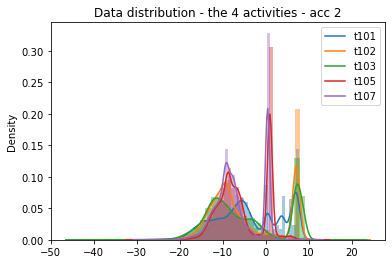

In [75]:
sub_sele = ['t101','t102','t103','t105','t107']
fig, axs = plt.subplots(1,1)
for k,v in subj.items():
    if k in sub_sele:
        sns.distplot(v,ax = axs)
axs.set_title('Data distribution - the 4 activities - acc 2')
axs.legend(sub_sele)

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


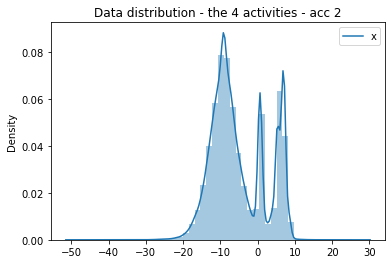

In [29]:
lim = 25
i = 0
fig, axs = plt.subplots(1,1)
sns.distplot(x_axis,ax = axs)
axs.set_title('Data distribution - the 4 activities - acc 2')
axs.legend(['x'])
#axs.set_xlim([-lim, lim])

### Reading all data Original
https://www.kaggle.com/avrahamcalev/time-series-models-pamap2-dataset

Reading in a differente way to check if there is an error in the last reading. 

In [5]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='C:\\Users\\gcram\\Documents\\Smart Sense\\Datasets\\originals\\PAMAP2\\Protocol\\subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [8]:
pama = data[['time_stamp',
             'activity_id',
             'hand_3D_acceleration_6_x',
          
             'hand_3D_acceleration_6_y',
             'hand_3D_acceleration_6_z',
             'hand_3D_gyroscope_x',
            'hand_3D_gyroscope_y',
            'hand_3D_gyroscope_z',
            'id']]

In [25]:
myPama = pama[pama['activity_id']==1] #lying
myPama =myPama.append(pama[pama['activity_id']==4])#walkin
myPama =myPama.append(pama[pama['activity_id']==12])#ascending
myPama =myPama.append(pama[pama['activity_id']==13])#descending


In [9]:
#pama = pama.sort_values(by=['time_stamp'])

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


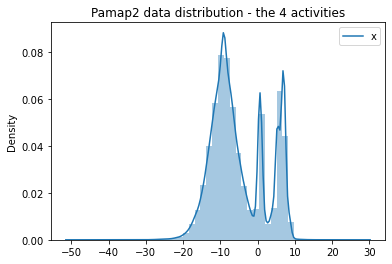

In [27]:
lim = 25
fig, axs = plt.subplots(1,1)
sns.distplot(myPama[['hand_3D_acceleration_6_x']].values.flatten(),ax = axs)
axs.set_title('Pamap2 data distribution - the 4 activities')
axs.legend(['x'])
#axs.set_xlim([-lim, lim])


#### Analysing LOSO data: Arthur processing.

In [35]:
path = "C:\\Users\\gcram\\Downloads\\"
file = os.path.join(path, 'PAMAP2P.npz')
with np.load(file,allow_pickle= True) as tmp:
    X = tmp['X'].astype('float32')
    y = np.argmax(tmp['y'],axis = 1)


In [36]:
# não dá para saber quais são as atividades... 
#pq só 12 act?
pd.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

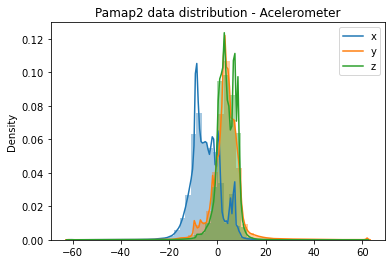

In [12]:
x_acc1 = X[:,0,:,4:7]
lim = 25
i = 0
fig, axs = plt.subplots(1,1)
sns.distplot(x_acc1[:,:,0].flatten(),ax = axs)
sns.distplot(x_acc1[:,:,1].flatten(),ax = axs)
sns.distplot(x_acc1[:,:,2].flatten(),ax = axs)
axs.set_title('Pamap2 data distribution - Acelerometer')
axs.legend(['x','y','z'])


In [11]:
X[:,0,:,4:7].max()

62.2598

### Analysing the processed Data:

In [10]:
myActNames = {
	'walking': 0,
	'walking forward': 0,
	'ascending stairs': 1,
	'walking up': 1,
	'descending stairs': 2,
	'walking down': 2,
	'lying':3,
	'lying on back':3,
	'lying on right':3,
	'laying':3,
	'sleeping':3,
	'sitting': 4,
	'standing': 5,
}
idx2Name = {
	0:'walking',
	1:'ascending stairs',
	2:'descending stairs',
	3:'lying',
}
def standarizeActName(y):
    y1 = list(map(lambda x: x.split('-')[-1], y))
    return np.array(list(map(lambda x: myActNames[x], y1)))

def readDataset(dataset_name):
    #file = os.path.join(DATA_DIR, f'{dataset_name}_f25_t2_{n_classes}actv.npz')
    file = os.path.join(DATA_DIR, f'{dataset_name}_v2.npz')
    with np.load(file, allow_pickle=True) as tmp:
        X = tmp['X'].astype('float32')
        y = tmp['y']
    Y = standarizeActName(y)
    return X[:,0,:,:],Y

In [11]:
x,y = readDataset("Pamap2")
actv = pd.value_counts(y)


In [7]:
actv

Pamap2-ascending stairs     1555
Pamap2-walking              1545
Pamap2-descending stairs    1329
Pamap2-lying                 598
dtype: int64

In [66]:
def normalize(X,Y):
    newX = []
    newY = []
    tol = 3
    m = np.array([np.mean(X[:,:, i]) for i in range(X.shape[-1])])
    std = np.array([np.std(X[:,:,i]) for i in range(X.shape[-1])])
    out_up = m + tol*std
    out_down = m - tol*std



    for sample,label in zip(X,Y):
        #check if this sample is an outlier:
        min_ = np.min(sample,axis = 0)
        max_ = np.max(sample,axis = 0)

        if ((out_up < max_) + 0).sum() + ((out_down > min_) + 0).sum() == 0:
            # normalization [-0.5, 0.5]

            new_sample = (sample - out_down)/(out_up-out_down) - 0.5
            #new_sample = (sample - m)/std
            newX.append(new_sample)
            newY.append(label)
    return np.array(newX),np.array(newY)

In [67]:
x_norm,y_norm = normalize(x,y)

In [59]:
pd.value_counts(y_norm)

1    1555
0    1545
2    1329
3     598
dtype: int64

In [8]:
sys.path.insert(0, '../')
from Utils.visualization import plot_sensor

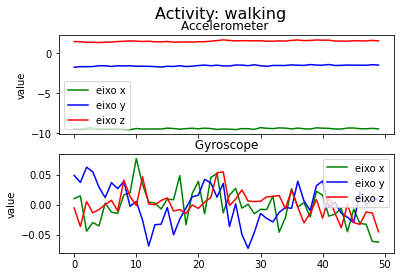

In [22]:
#filter some activity:
%matplotlib inline
act_idx = 0
x_act = x[np.where(y==act_idx)[0]]
sample = -3
plot_sensor(x_act[sample][None,:,:],idx2Name[act_idx])


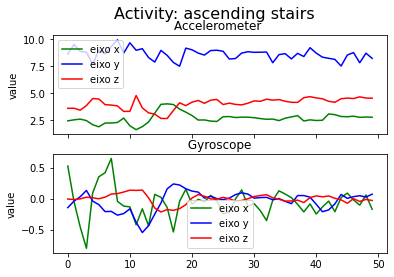

In [15]:
#filter some activity:
%matplotlib inline
act_idx = 1
x_act = x[np.where(y==act_idx)[0]]
sample = 0
plot_sensor(x_act[sample][None,:,:],idx2Name[act_idx])

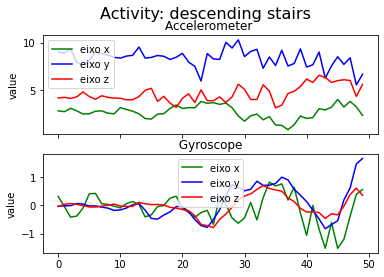

In [16]:
#filter some activity:
%matplotlib inline
act_idx = 2
x_act = x[np.where(y==act_idx)[0]]
sample = 0
plot_sensor(x_act[sample][None,:,:],idx2Name[act_idx])

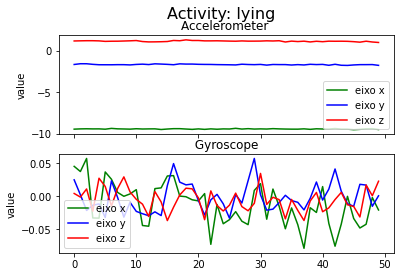

In [23]:
#filter some activity:
%matplotlib inline
act_idx = 3
x_act = x[np.where(y==act_idx)[0]]
sample = -1
plot_sensor(x_act[sample][None,:,:],idx2Name[act_idx])

### Plot Normalized Data:

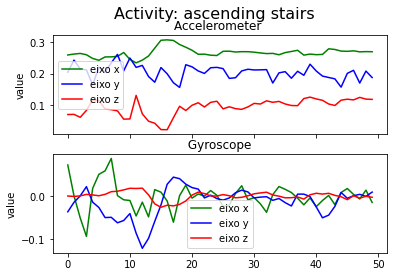

In [61]:
%matplotlib inline
act_idx = 1
x_act = x_norm[np.where(y_norm==act_idx)[0]]
sample = 0
plot_sensor(x_act[sample][None,:,:],idx2Name[act_idx])

In [52]:
x.shape

(5027, 50, 6)

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

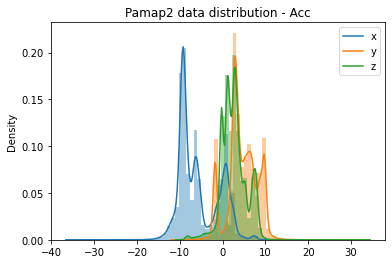

In [8]:
lim = 25
i = 0
act_idx = 3
x_act = x[np.where(y==act_idx)[0]]

fig, axs = plt.subplots(1,1)
sns.distplot(x_act[:,:,0].flatten(),ax = axs)
sns.distplot(x_act[:,:,1].flatten(),ax = axs)
sns.distplot(x_act[:,:,2].flatten(),ax = axs)
axs.set_title('Pamap2 data distribution - Acc')
axs.legend(['x','y','z'])

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

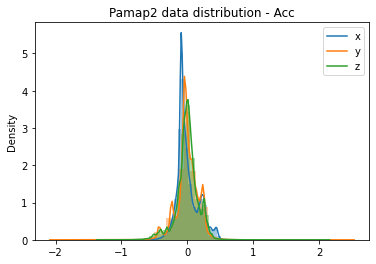

In [64]:
lim = 25
i = 0
fig, axs = plt.subplots(1,1)
sns.distplot(x_norm[:,:,0].flatten(),ax = axs)
sns.distplot(x_norm[:,:,1].flatten(),ax = axs)
sns.distplot(x_norm[:,:,2].flatten(),ax = axs)
axs.set_title('Pamap2 data distribution - Acc')
axs.legend(['x','y','z'])

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

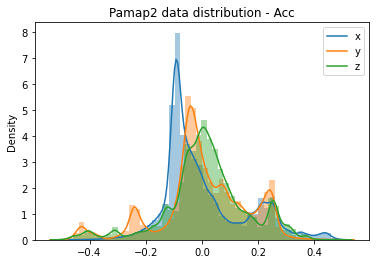

In [68]:
lim = 25
i = 0
fig, axs = plt.subplots(1,1)
sns.distplot(x_norm[:,:,0].flatten(),ax = axs)
sns.distplot(x_norm[:,:,1].flatten(),ax = axs)
sns.distplot(x_norm[:,:,2].flatten(),ax = axs)
axs.set_title('Pamap2 data distribution - Acc')
axs.legend(['x','y','z'])

Comparing with other dataset

In [44]:
other_dat = "Ucihar"
x_other,y_other = readDataset(other_dat)


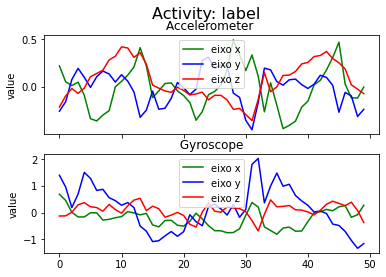

In [45]:
x_other_act = x_other[np.where(y_other==1)[0]]
sample = 5
plot_sensor(x_other_act[sample][None,:,:],)

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

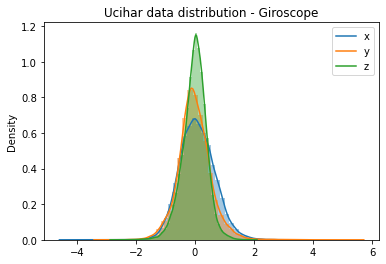

In [46]:
lim = 25
i = 0
fig, axs = plt.subplots(1,1)
sns.distplot(x_other_act[:,:,3].flatten(),ax = axs)
sns.distplot(x_other_act[:,:,4].flatten(),ax = axs)
sns.distplot(x_other_act[:,:,5].flatten(),ax = axs)
axs.set_title(f'{other_dat} data distribution - Giroscope')
axs.legend(['x','y','z'])